In [ ]:
# Install OSMNX only if working on Google Colab
import sys
IN_COLAB = 'google.colab' in sys.modules
if IN_COLAB:
    !pip install osmnx
    !pip install matplotlib==3.1.1

In [1]:
# Load datasets if working on Google Colab
import sys
IN_COLAB = 'google.colab' in sys.modules
if IN_COLAB:
    from pydrive.auth import GoogleAuth
    from pydrive.drive import GoogleDrive
    from google.colab import auth
    from oauth2client.client import GoogleCredentials
    auth.authenticate_user()
    gauth = GoogleAuth()
    gauth.credentials = GoogleCredentials.get_application_default()
    drive = GoogleDrive(gauth)
    file_id = '...'
    downloaded = drive.CreateFile({'id':file_id})
    downloaded.FetchMetadata(fetch_all=True)
    downloaded.GetContentFile(downloaded.metadata['title'])
    f = open("V2data_6mounts2022.csv.zip", "wb")
    f.write(downloaded.content.getbuffer())
    f.close()
    !unzip V2data_6mounts2022.csv.zip

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import pickle
import requests
import cloudpickle as cp
from urllib.request import urlopen

IN_COLAB = 'google.colab' in sys.modules
if IN_COLAB:
    r = requests.get('https://raw.githubusercontent.com/dominik117/cortexia-darkzones-prediction/main/src/helper_scripts/data_processor.py')
    with open('data_processor.py', 'w') as f:
        f.write(r.text)
        import data_processor
else:
    sys.path.insert(1, '../../src/')
    import helper_scripts.data_processor as data_processor

sns.set_style('whitegrid')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 300)

# Dataset Import

In [6]:
IN_COLAB = 'google.colab' in sys.modules
if IN_COLAB: df_main_url = '/content/data.csv'
else: df_main_url = '../../data/datav2.csv'
df_main = pd.read_csv(df_main_url, dtype = {'place.id': object})

sys.path.append("/")

df_main = data_processor.clean_df(df_main)
df_main = data_processor.aggregate_df(df_main)
df_main = data_processor.create_date_features(df_main)
df_main = data_processor.create_coordinates_features(df_main, file_path='../../data/edges.geojson')
df_main = data_processor.create_weather_features(df_main, file_path='../../data/weather_basel_2021-2022.csv')
df_main = data_processor.create_osm_features(df_main)
osm_columns = data_processor.create_osm_columns()
# Runtime ~3 minutes

# Models and Xtest

In [ ]:
if IN_COLAB:
    url = "https://github.com/dominik117/data-science-toolkit/blob/main/data/models_dictionary.pkl?raw=true"
    models = cp.load(urlopen(url)) 
else:
    with open('../../data/models_dictionary.pkl', 'rb') as f:
        models = pickle.load(f)

from sklearn.model_selection import train_test_split
def train_test(df, output):
    columns_to_drop = ['total_litter', 'total_litter_ratio']
    columns_to_drop.extend(data_processor.get_litter_columns(df))
    X = df_main.drop(columns=columns_to_drop, errors='ignore')
    y = df_main[output]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = train_test(df_main, '1')

# Prediction Testing

In [5]:
np.random.seed(42)
df_main_predicted = df_main.copy()
for key, model in models.items():
    predictions = model[0].predict(df_main_predicted)
    predictions = np.rint(predictions).astype(int)
    df_main_predicted[f"{key}_pred"] = predictions
columns_to_drop = ['Year', 'month', 'day', 'weekday', 'holiday', 'lat_north', 'lat_south', 'lon_east', 'lon_west', 'edge_length', 
        'temperature_max', 'temperature_min', 'temperature_mean', 'precipitation', 'snowfall', 'humidity_max', 'humidity_min', 
        'humidity_mean', 'cloud_coverage', 'wind_speed_max', 'wind_speed_min', 'wind_speed_mean']
columns_to_drop.extend(osm_columns)
df_main_predicted.drop(columns_to_drop, axis=1, inplace=True, errors='ignore')
# Runtime ~2 minutes

In [ ]:
def aggregate_edges(df, litter, start=False, end=False):
    df_main_predicted = df
    df_test = df_main_predicted[['date_utc', 'edge_id', f'{litter}', f'{litter}_pred']]
    df_test = df_test.groupby(['edge_id'], as_index=False).agg({f'{litter}':'sum', f'{litter}_pred':'sum'})
    df_test = df_test.sample(n=14000, random_state=5).copy().reset_index(drop=True)

    agg_n_edges = []
    end = end+1
    if start < 2: start = 2
    for x in range(start, end):
        if (x<50) & (x%1==0): agg_n_edges.append(x)
        if (49<x<6500) & (x%50==0): agg_n_edges.append(x)
        #if (6500<x<7000) & (x%300==0): agg_n_edges.append(x)
        if (6500<x<13000) & (x%100==0): agg_n_edges.append(x)
        if (13000<x<14001) & (x%1000==0): agg_n_edges.append(x)

    ticks = []
    relative_error = []
    for n_edges in agg_n_edges:
        ###
        indices, df_indices = [], []
        for num in range(0, int(14000/n_edges)+1):
            indices.append(num)
        counter = 0
        while counter != 14000:
          for item in indices:
            df_indices.append(item)
            counter += 1
            if counter == 14000:
              break
        df_indices = pd.Int64Index(df_indices)
        ### df_test.index // n_edges

        df_loop = df_test.groupby(df_test.index // n_edges).agg({f'{litter}':'sum', f'{litter}_pred':'sum'})
        errors = []
        for row in df_loop.values:
            diff = abs(row[1] - row[0])
            if row[0] > 0:
              error = round((diff*100)/row[0], 8)
            else:
              error = round((diff*100)/1, 8)
            errors.append(error)
        errors = np.array(errors)
        relative_error.append([n_edges, round(np.mean(errors), 2)])
        ticks.append([n_edges, errors])
    return ticks, relative_error

ticks1, relative_error1 = aggregate_edges(df_main_predicted, "1", start=50, end=14000)
ticks2, relative_error2 = aggregate_edges(df_main_predicted, "2", start=50, end=14000)
ticks4, relative_error4 = aggregate_edges(df_main_predicted, "4", start=50, end=14000)

In [ ]:
relative_error1 = np.array(relative_error1)
relative_error2 = np.array(relative_error2)
relative_error4 = np.array(relative_error4)

fig, ax = plt.subplots(figsize=(26, 12))
ax.plot(relative_error1[:, 0], relative_error1[:, 1], color="#087E8B")
ax.plot(relative_error2[:, 0], relative_error2[:, 1], color="DarkGoldenRod")
ax.plot(relative_error4[:, 0], relative_error4[:, 1], color="DarkSlateGrey")
for array in ticks1:
  for tick in array[1]:
    if (tick < 7):
      ax.scatter(x=array[0], y=tick, color="LightSlateGrey", s=1, alpha=1)
for array in ticks4:
  for tick in array[1]:
    if (tick < 7):
      ax.scatter(x=array[0], y=tick, color="LightSlateGrey", s=1, alpha=1)
newXlabels = ['0', '50', '2000', '4000', '6000', '8000', '10000', '12000', '14000']
plt.gca().set_xticklabels(newXlabels)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.xlabel('Street Grouping', fontsize=28) 
plt.ylabel('Error Margin %', fontsize=28)
plt.show()

In [8]:
models_sorted = dict(sorted(models.items(), key=lambda item: item[1][2], reverse=True))

In [12]:
df_test = X_test.copy()
for key, model in models_sorted.items():
    predictions = model[0].predict(df_test)
    predictions = np.rint(predictions).astype(int)
    df_test[f"{key}_real"] = model[1]
    df_test[f"{key}_pred"] = predictions

columns_to_drop = ['Year', 'month', 'day', 'weekday', 'holiday', 'lat_north', 'lat_south', 'lon_east', 'lon_west', 'edge_length', 
        'temperature_max', 'temperature_min', 'temperature_mean', 'precipitation', 'snowfall', 'humidity_max', 'humidity_min', 
        'humidity_mean', 'cloud_coverage', 'wind_speed_max', 'wind_speed_min', 'wind_speed_mean']
df_test.drop(columns_to_drop, axis=1, inplace=True, errors='ignore')
# df_test = df_test[df_test['4_real'] < 8]
# df_test = df_test[df_test['4_pred'] > 30]
sample_num = 40
df_test = df_test.sample(n=sample_num).copy()

In [10]:
def make_scatter(df, y, x='edge_id'):
    y_real = f"{y}_real"
    y_pred = f"{y}_pred"

    fig, ax = plt.subplots(figsize=(15, 7))
    ax.set_title(f"Litter {y} {models_sorted[y][4]} - D2 Score: {models_sorted[y][2]}", pad=20)
    max_value = max(df[y_real].max(), df[y_pred].max())
    #ax.text(12, (max_value+10), f'D2 Score: {models_sorted[y][2]}', fontsize=15)
    ax.scatter(data=df, x=x, y=y_real, color='green', s=140)
    ax.scatter(data=df, x=x, y=y_pred, color='brown', s=70)
    for i in df.index:
      if df.loc[i, y_real] > df.loc[i, y_pred]:
        plt.vlines(x=df.loc[i, 'edge_id'], ymin= df.loc[i, y_pred], ymax= df.loc[i, y_real], colors='lightgrey')
      else:
        plt.vlines(x=df.loc[i, 'edge_id'], ymin= df.loc[i, y_real], ymax= df.loc[i, y_pred], colors='lightgrey')
    labels = [f'e{x}' for x in range(1, (sample_num+1))]
    ax.set_xticks(range(sample_num))
    ax.set_xticklabels(labels)
    plt.xlabel('Random Edge')
    plt.ylabel('Litter Count')
    ax.legend()
    plt.show()

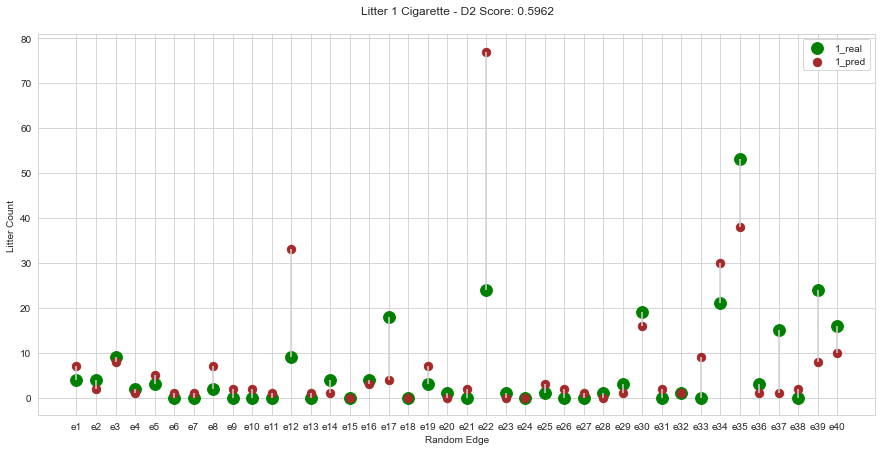

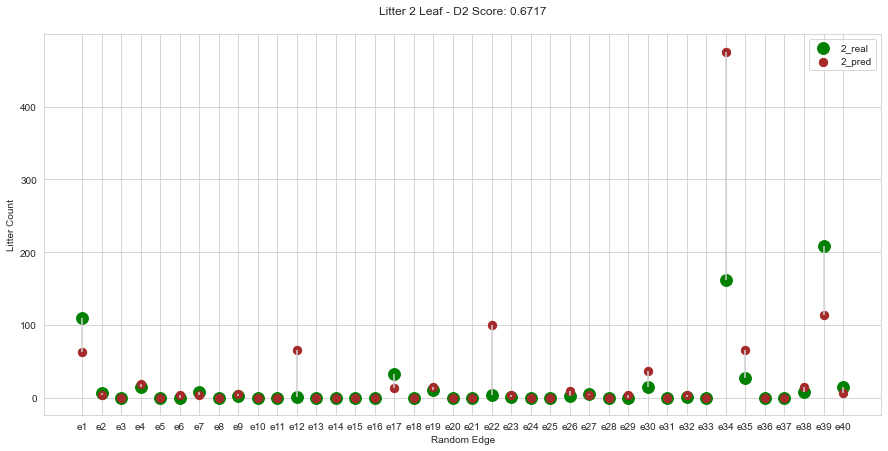

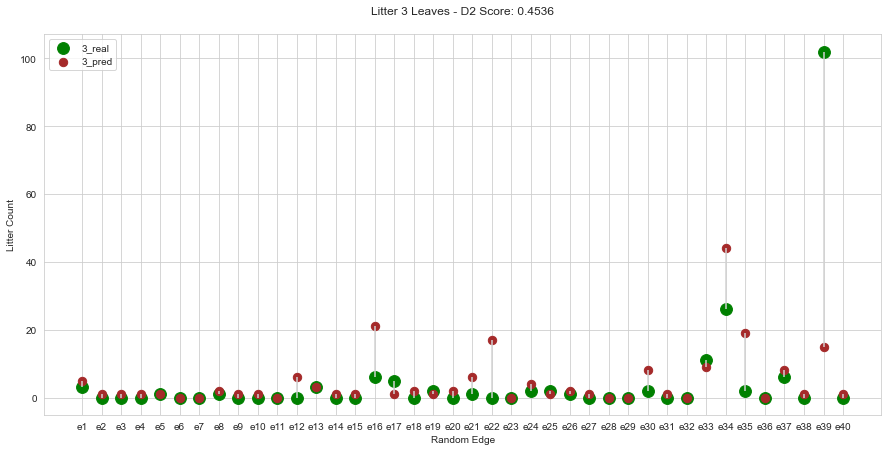

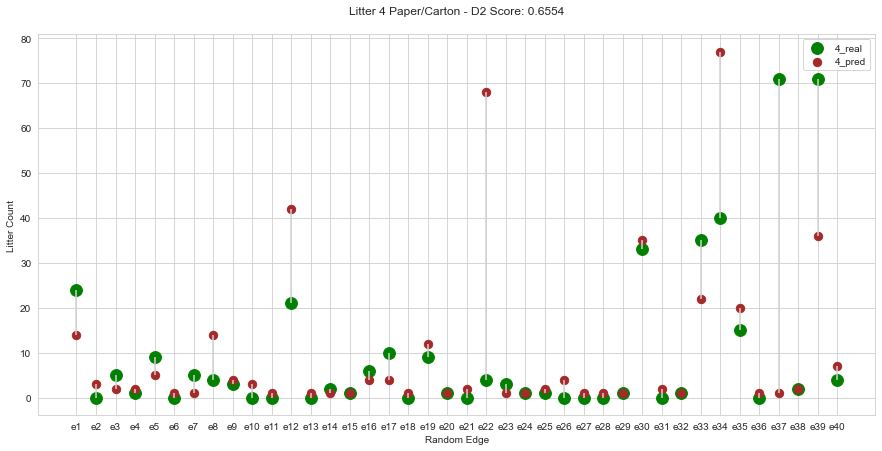

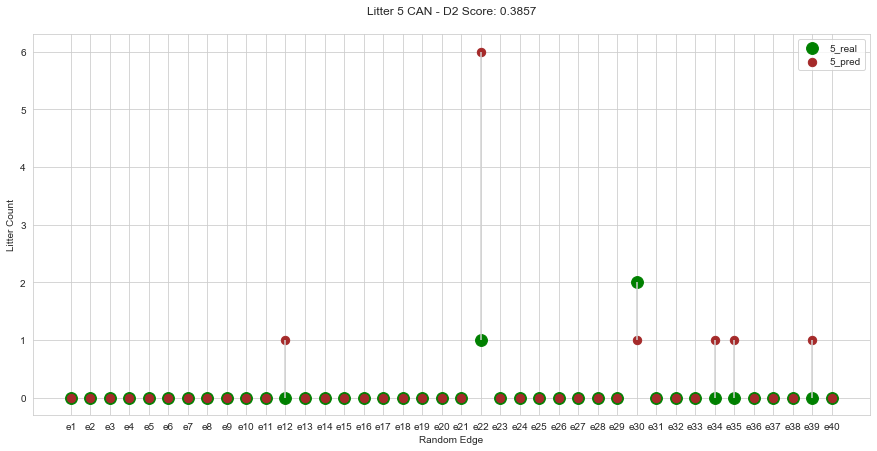

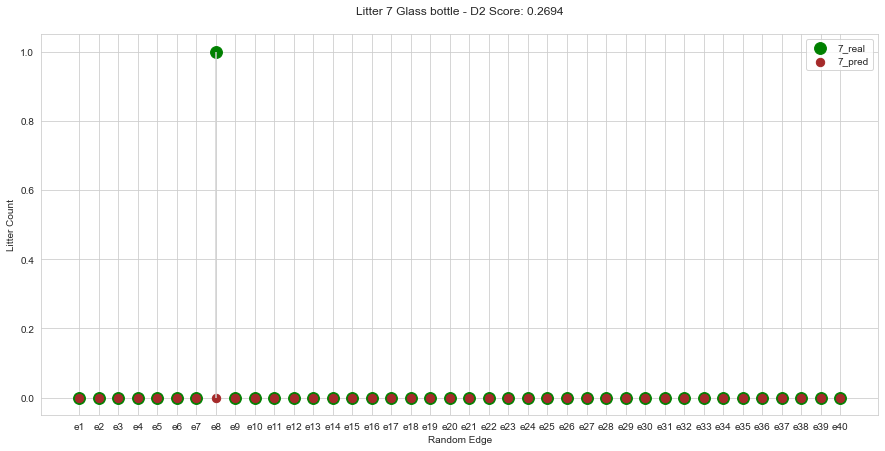

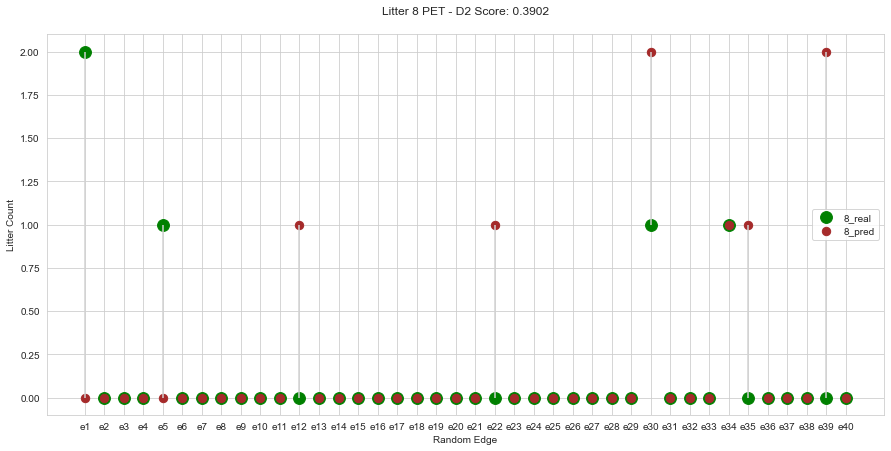

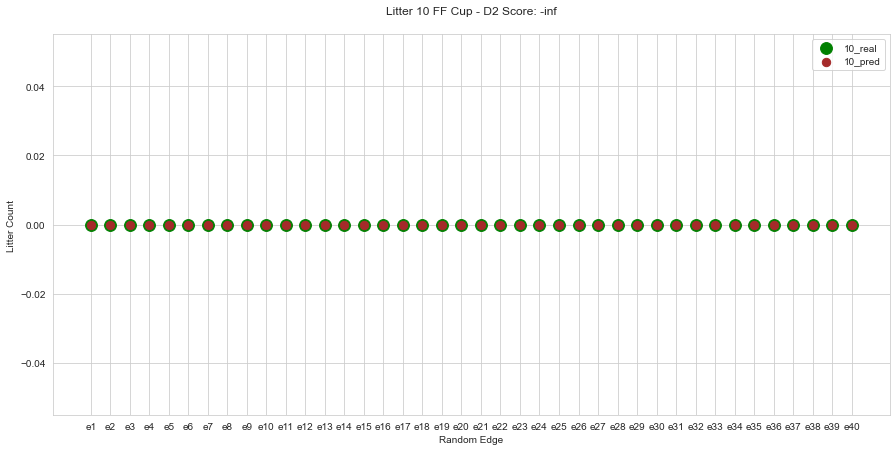

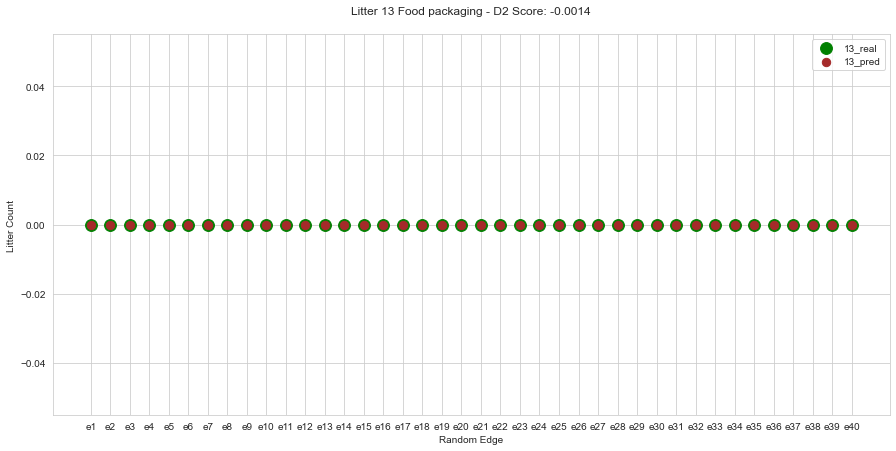

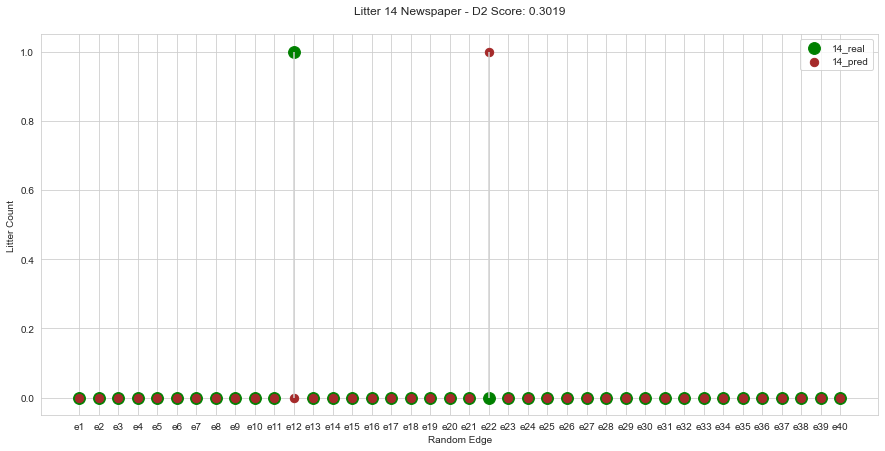

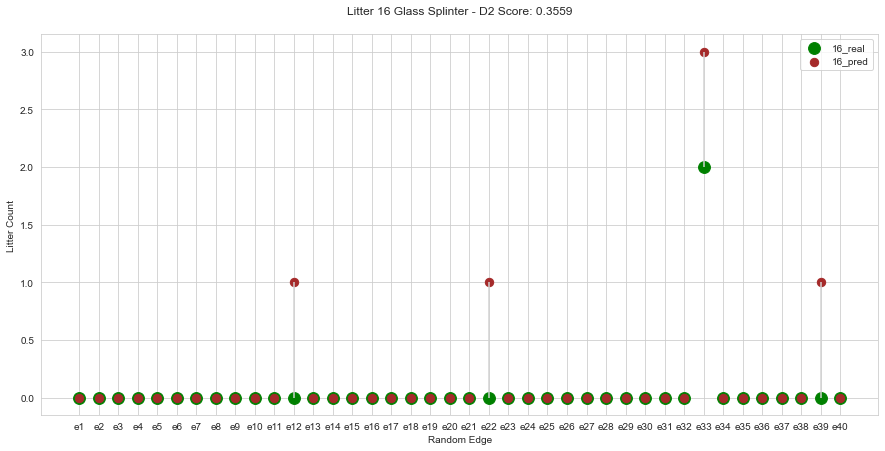

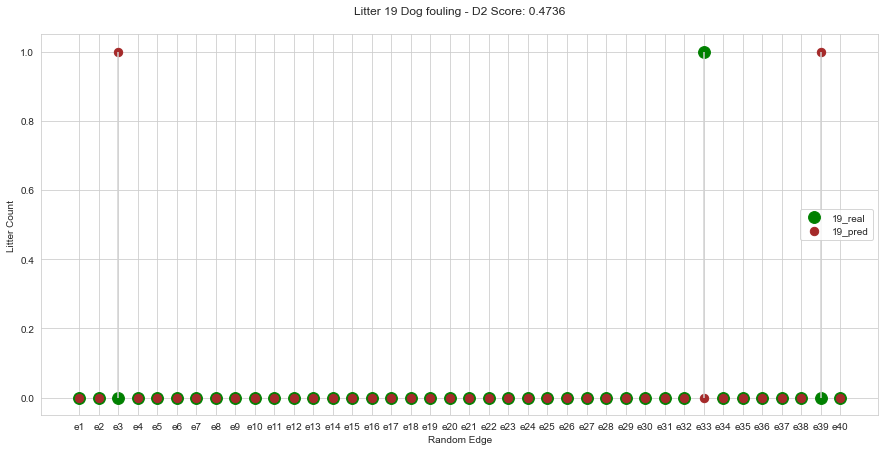

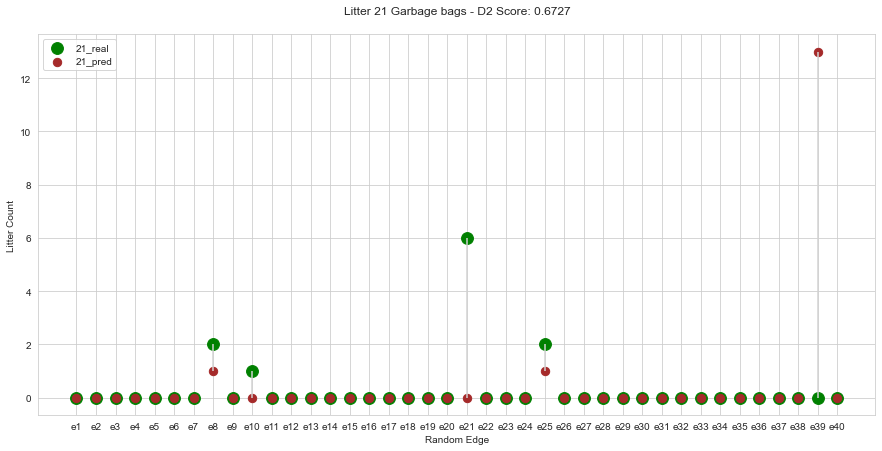

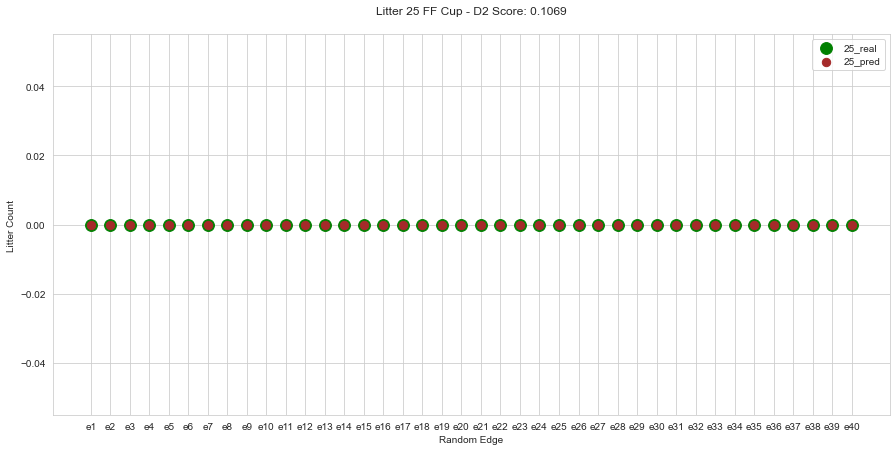

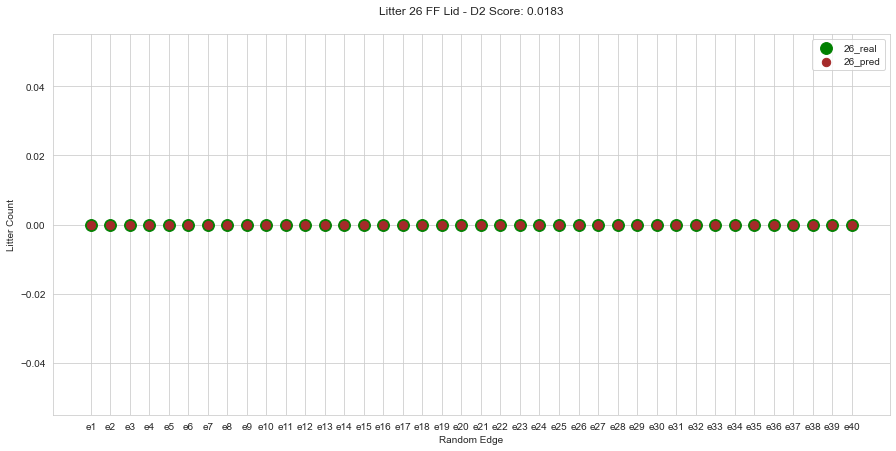

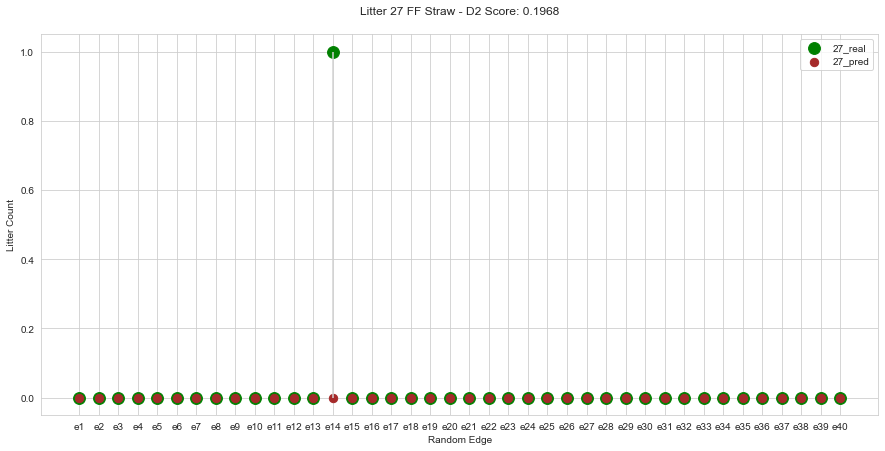

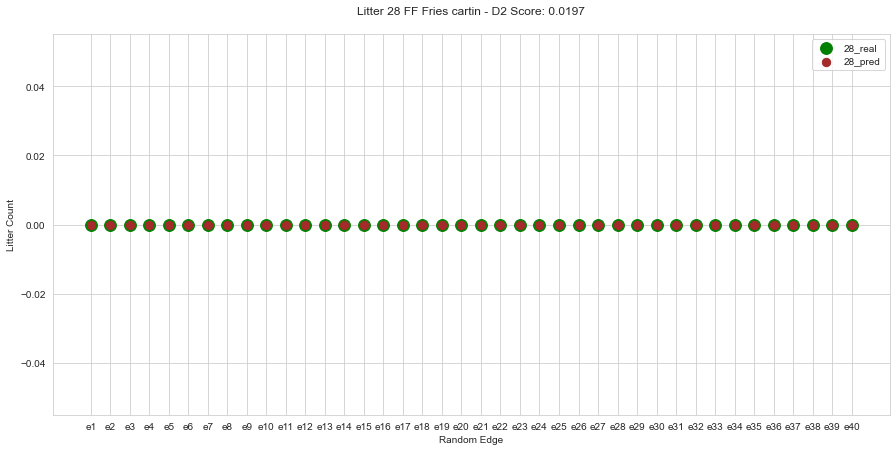

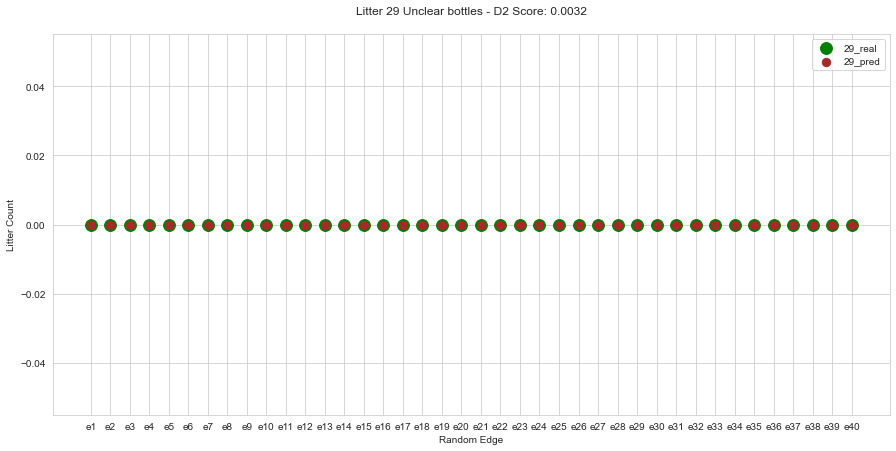

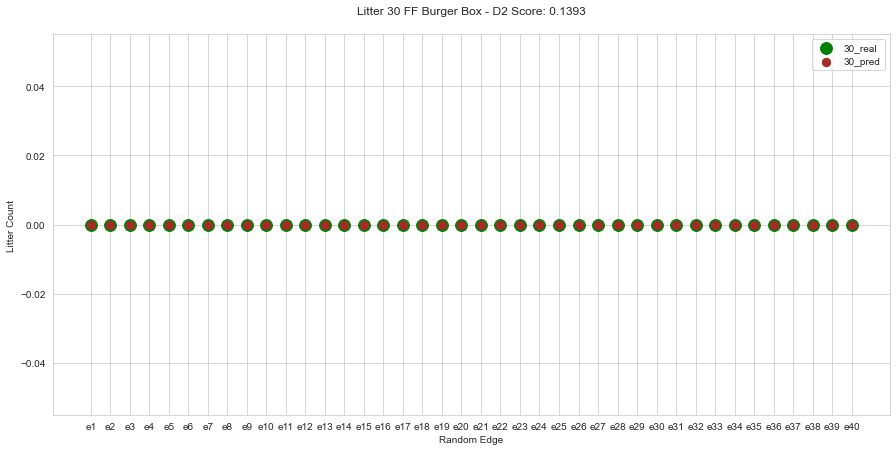

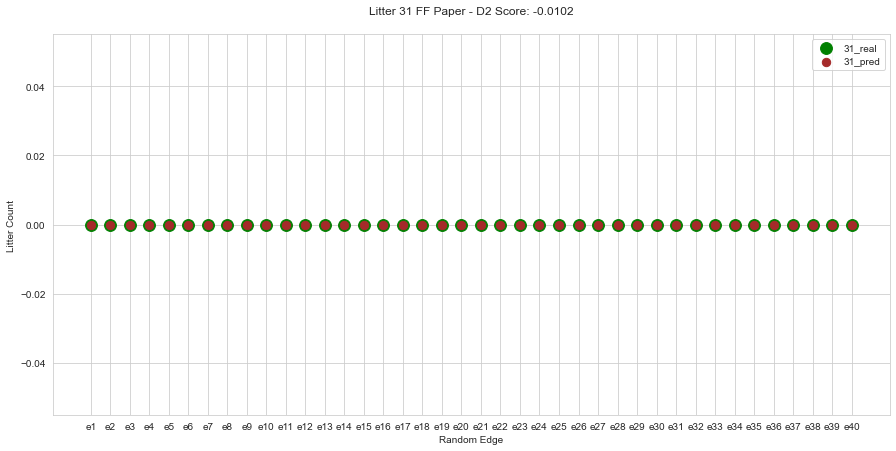

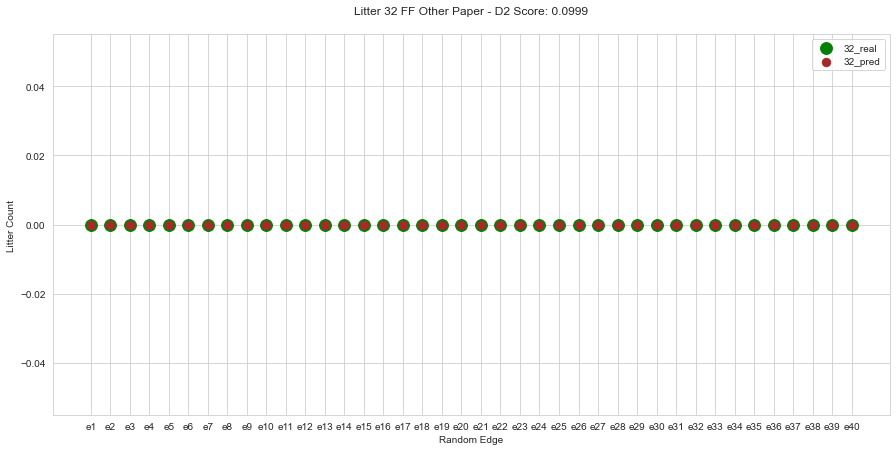

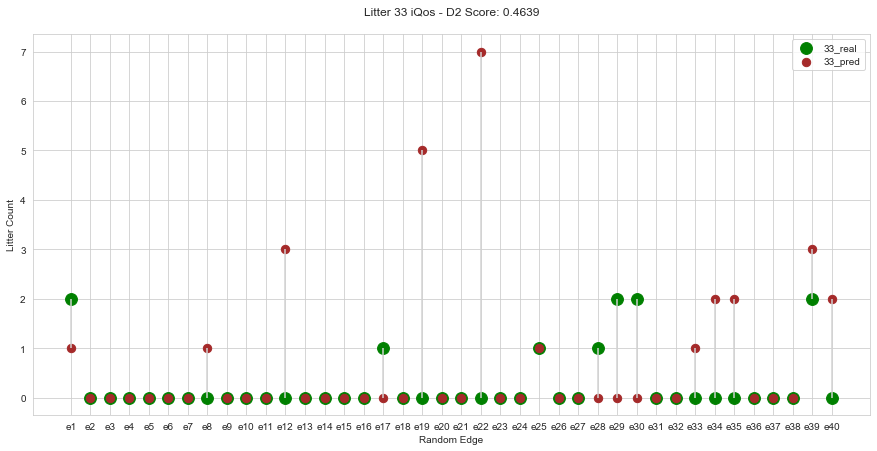

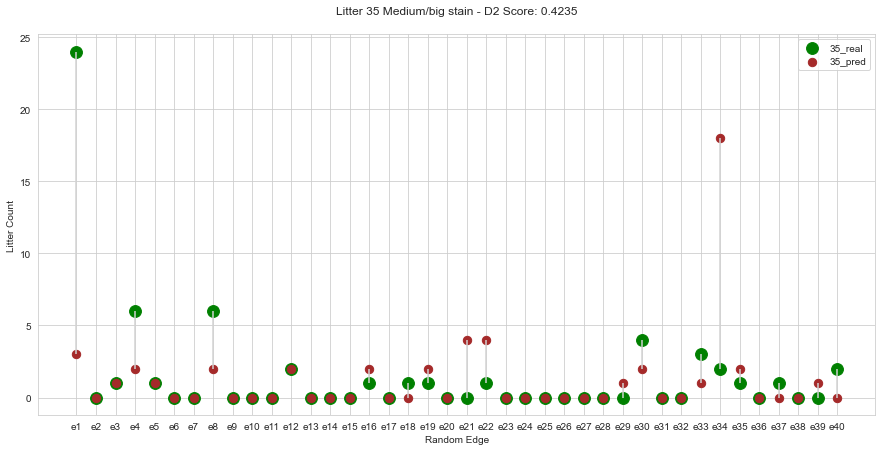

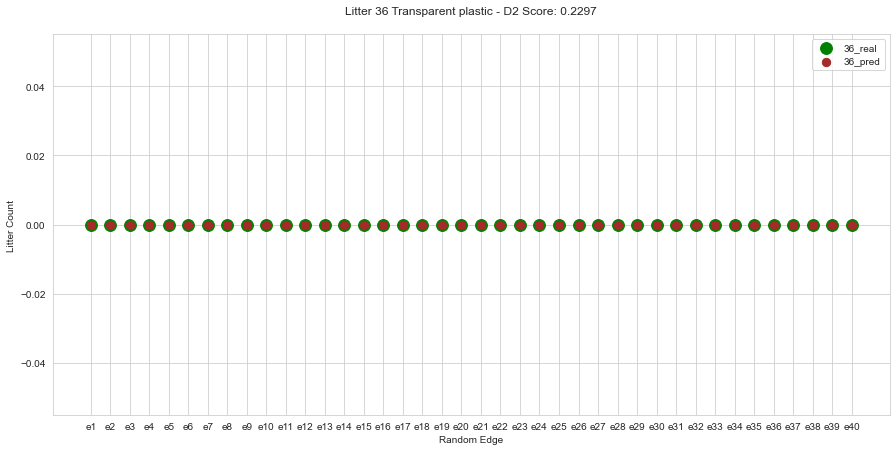

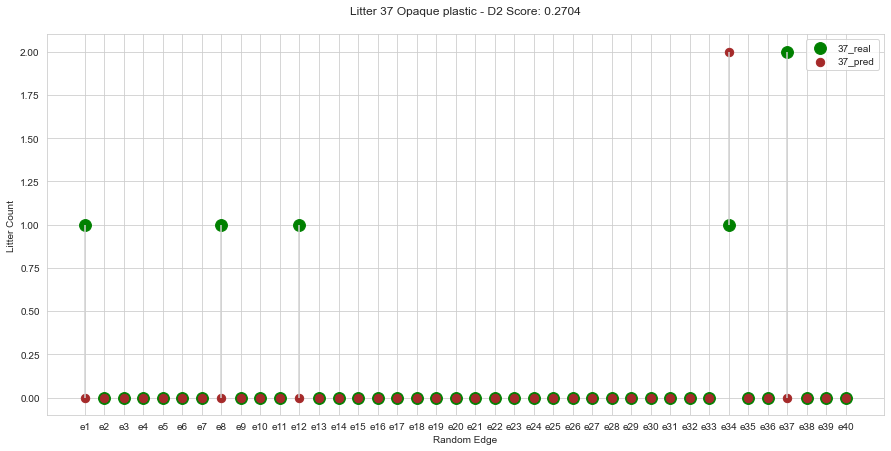

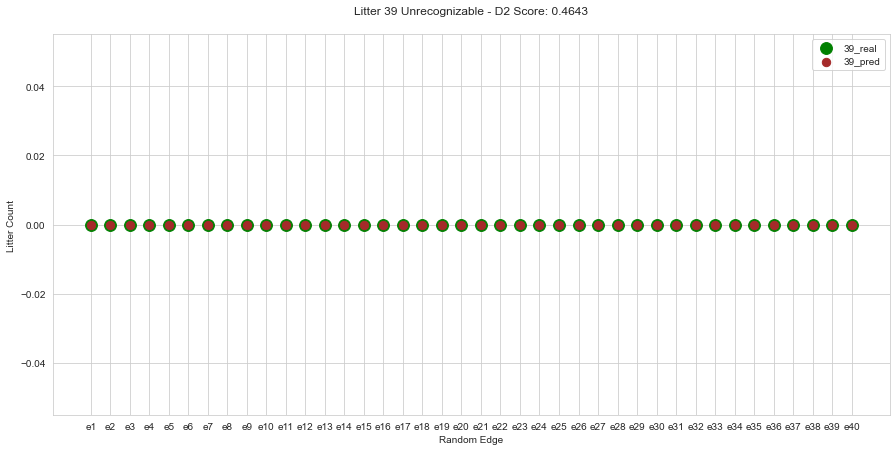

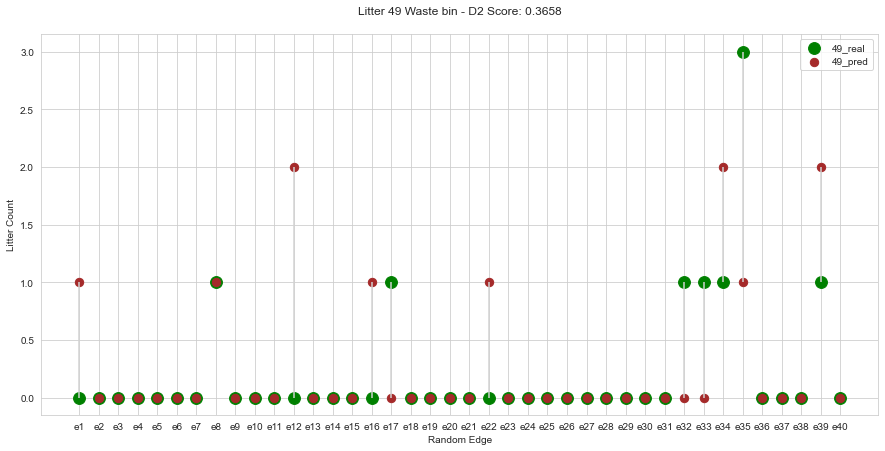

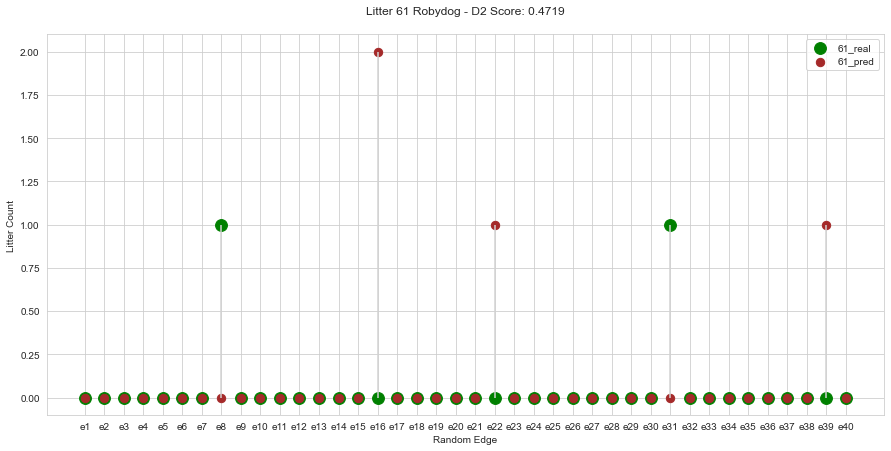

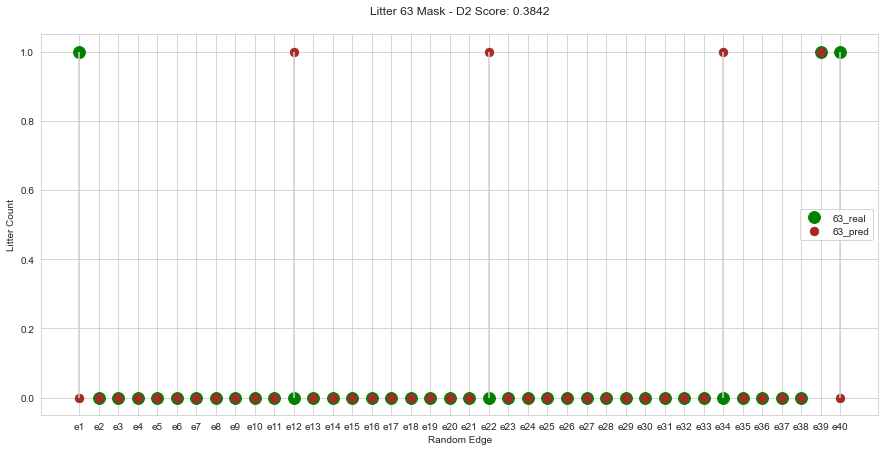

In [13]:
litter_columns = data_processor.get_litter_columns(df_main)
for litter in litter_columns:
    make_scatter(df_test, litter)

In [20]:
for key, model in models_sorted.items():
    print(f"{key} {model[4]}: {model[2]}")

21 Garbage bags: 0.6727
2 Leaf: 0.6717
4 Paper/Carton: 0.6554
total_litter Total Litter: 0.6361
1 Cigarette: 0.5962
19 Dog fouling: 0.4736
61 Robydog: 0.4719
39 Unrecognizable: 0.4643
33 iQos: 0.4639
3 Leaves: 0.4536
35 Medium/big stain: 0.4235
8 PET: 0.3902
5 CAN: 0.3857
63 Mask: 0.3842
49 Waste bin: 0.3658
16 Glass Splinter: 0.3559
14 Newspaper: 0.3019
37 Opaque plastic: 0.2704
7 Glass bottle: 0.2694
36 Transparent plastic: 0.2297
27 FF Straw: 0.1968
30 FF Burger Box: 0.1393
25 FF Cup: 0.1069
32 FF Other Paper: 0.0999
28 FF Fries cartin: 0.0197
26 FF Lid: 0.0183
29 Unclear bottles: 0.0032
13 Food packaging: -0.0014
31 FF Paper: -0.0102
10 FF Cup: -inf
